In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# *Exploratory data analysis* (EDA) e pré-processamento

Afim de deixar esse repositório mais organizado resolvi separar toda etapa pré treinamento em um notebook, e todo o treinamento e testes do modelo em outro. Como a EDA e o pré processamento estão intimamente ligados achei melhor mantê-los juntos. A partir das análises consigo criar novas features, que devem passar pelo processo de análise novamente. É praticamente um processo recursivo até ter um conjunto de dados bom o suficiente para que o modelo use no treinamento.

O objetivo dessa etapa é identificar padrões e correlações dos dados, e identificar features que possam contribuir para o poder preditivo do modelo. É um problema de classificação binária, onde o modelo deve prever se a variável `Transported` é `True` ou `False`. O modelo é treinado a partir de um conjunto de dados onde a variável alvo (`Transported`) é dada, e o modelo deve prever o valor para o conjunto teste. 

## Carregando os dados

In [52]:
train_pd = pd.read_csv('train.csv')
test_pd = pd.read_csv('test.csv')

X_train = train_pd.drop('Transported', axis=1)
Y_train = train_pd['Transported'].copy()
Y_train = Y_train.astype(int)

## Contextualizando o problema

Antes de começar a de fato olhar para os dados preciso falar sobre o problema que estamos atacando. No ano de 2912 a espaçonave Titanic, com quase 13000 pessoas à bordo, colidiu com uma anomalia no espaço tempo escondida atrás de uma nuvem de poeira, resultando no desaparecimento de algum dos passageiros. O problema nos fornece os dados dos passageiros como: Cabine, valor gasto na nave (serviço de quarto, spa, etc.), planeta natal e planeta de destino, entre outros (Alguns desse valores estão faltando para alguns passageiros). A situação (desaparecido ou não) é conhecida apenas de alguns passageiros, e o objetivo da competição é prever a situação do restante dos passageiros a partir dos dados fornecidos. Resumindo, devemos treinar um modelo com os dados das pessoas cuja situação é conhecida para prever a situação das demais.

In [53]:
print(f'Sei a situação de {train_pd.shape[0]} passageiros e preciso descobrir a situação de {test_pd.shape[0]} passageiros ({train_pd.shape[0]+test_pd.shape[0]} passageiros no total)')

Sei a situação de 8693 passageiros e preciso descobrir a situação de 4277 passageiros (12970 passageiros no total)


## Definindo as funções para visualizar os dados

Aqui vou criar algumas funções importantes para a visualização e exploração de um conjunto com diferentes tipos de dados. Por enquanto esses conjuntos de funções será utlizado para exibir um *bar plot* com o número de *missing values* por *feature* (para preparar o processo de imputação), analisar histogramas dos dados numéricos afim de ver sua distribuição em relação à variável alvo (por exemplo, como está distribuída a *feature* `Age` para as pessoas que foram transportada? Está igual à das pessoas que não foram transportadas?), criar *pie plots* com os valores únicos das variáveis categóricas e analisar a frequência das variáveis binárias, e também olhar para algumas outras características numéricas através da função .describe() do pandas. 

In [54]:
def count_miss(df: pd.DataFrame, dscb=True):
    #Função que plota um gráficos de barras para indicar quantos valores faltam no conjunto de dados
    # df --> dataframe
    # dscb --> Mostrar descrição geral dos dados

    if dscb:
        print(df.describe(include='all'))
    
    miss = df.isnull().sum() #dataframe com os missing values

    plt.figure(figsize=(10, 5))
    cores = plt.cm.get_cmap('hsv', len(miss)) #mapa de cores

    barras = plt.bar(range(len(miss)), miss.values, color=cores(range(len(miss))))

    plt.xticks([])
    plt.ylabel('Número de Missing Values')
    plt.title('Missing Values por Coluna')

    plt.legend(barras, [f"{idx}: {val}" for idx, val in miss.items()], bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()

def hist_num(df_train: pd.DataFrame, ftrs: list, targ: str, df_test=pd.DataFrame([]), uplim=9e20, downlim=-1, nolim=[], nb=60, dscb=True):
    # Função que plota histogramas para as variáveis numéricas e no final mostra a matriz de correlação entre as variáveis.
    # dataframe com os dados
    # ftrs --> lista com nomes das colunas com features numéricas
    # targ --> String com o index da coluna da variável alvo
    # uplim --> limite superior para o plot
    # downlim --> limite ingerior para o plot
    # nolim --> Lista com colunas que não são afetadas pelo uplim e downlim (Aqui usada apenas para 'Age')
    # nb --> Número de canais nos histogramas
    # dscb --> Mostrar descrição geral dos dados
    # df_test --> Se for o df de teste (não houver a variável alvo) colocar True

    if dscb:
        print(df_train.describe(include='all'))

    for col in ftrs:
        plt.figure(figsize=(10, 5))
        if (col in nolim) & (df_test.empty):
            sns.histplot(data=df_train[[col,targ]].fillna(0), x=col, hue=targ, 
                    bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} por Status de Transporte')
            plt.show()
            continue
        elif df_test.empty:
            nozero = df_train[(df_train[col] > downlim) & (df_train[col] < uplim)][[col, targ]].copy().fillna(0)
            sns.histplot(data=nozero, x=col, hue=targ, 
                    bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} para cada valor de {targ}')
            plt.show()
        elif (col in nolim) & (not df_test.empty):
            df_comp = pd.concat([
            df_train[[col]].assign(Fonte='Treino'),
            df_test[[col]].assign(Fonte='Teste')], ignore_index=True)
            sns.histplot(data=df_comp, x=col, hue='Fonte',
                        stat='probability', common_norm=False,
                        bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} para os dataset de treino e teste')
        else:
            df_comp = pd.concat([
            df_train[[col]].assign(Fonte='Treino'),
            df_test[[col]].assign(Fonte='Teste')], ignore_index=True)
            nozero = df_comp[(df_comp[col] > downlim) & (df_comp[col] < uplim)][col].copy().fillna(0)
            sns.histplot(data=df_comp, x=col, hue='Fonte',
                        stat='probability', common_norm=False,
                        bins=nb, kde=False, element='bars', legend=True)
            plt.title(f'Distribuição de {col} para os dataset de treino e teste')
        plt.show()


    

    if (df_test.empty):
        df_cp = df_train.copy() #Criando uma cópia para não alterar os dados
        df_cp['TransportedNum'] = df_cp[targ].astype(int) #Converte boolean pra int

        comat = df_cp[ftrs+['TransportedNum']].corr() #dataframe quadrado, correspodente à matriz de correlação

        plt.figure(figsize=(10,8))
        sns.heatmap(comat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) #mapa de calor da matriz de correlação
        plt.title('Matriz de correlação entre Features numéricas e Target')
        plt.show()
    
def pieplots(df_train: pd.DataFrame, ftrs: list, targ: str, df_test=pd.DataFrame([]), dscb=True):
    # Função que plota histogramas para as variáveis numéricas
    # dataframe com os dados
    # ftrs --> lista com nomes das colunas com features categóricas e binárias
    # targ --> String com o index da coluna da variável alvo

    fs = 12 #tamanho da fonte

    if dscb:
        print(df_train.describe(include='all'))
            
    if df_test.empty:
        for col in ftrs:
            counts_all = df_train[col].value_counts() #contagem de todos valores únicos

            sns.set_style("whitegrid")
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5)) #subplot, com 2 plots para cada conjunto de dados

            #primeiro plot (transportados)
            counts_trans = df_train[df_train[targ]==True][col].value_counts().sort_index()
            ax1.pie(
                counts_trans, 
                labels=counts_trans, 
                autopct='%1.1f%%', 
                startangle=90, 
                textprops={'fontsize':fs},
                labeldistance=.75,
                pctdistance = .5
                )
            ax1.set_title(f'{col} para {targ} = True', fontsize=fs+2)
            ax1.legend(
                [
                    f'{idx} ({val/sum(counts_all)*100:.1f}% das amostras, \n {counts_all[idx]/sum(counts_all)*100:.1f}% são {idx})' for idx,val in counts_trans.items()
                    ], 
                    bbox_to_anchor=(.9, 1), 
                    fontsize=fs
                    )

            #segundo plot (NÃO transportados)
            counts_nottrans = df_train[df_train[targ]==False][col].value_counts().sort_index()
            ax2.pie(
                counts_nottrans, 
                labels=counts_nottrans, 
                autopct='%1.1f%%', 
                startangle=90, 
                textprops={'fontsize':fs},
                labeldistance=.75,
                pctdistance = .5
                )
            ax2.set_title(f'{col} para {targ} = False', fontsize=fs+2)
            ax2.legend(
                [
                    f'{idx} ({val/sum(counts_all)*100:.1f}% das amostras, \n {counts_all[idx]/sum(counts_all)*100:.1f}% são {idx})' for idx,val in counts_nottrans.items()
                    ], 
                    bbox_to_anchor=(.9, 1), 
                    fontsize=fs
                    )
    else:
        for col in ftrs:
            sns.set_style("whitegrid")
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
            
            counts_trans = df_train[col].value_counts().sort_index()
            ax1.pie(
                counts_trans, 
                labels=counts_trans, 
                autopct='%1.1f%%', 
                startangle=90, 
                textprops={'fontsize':fs},
                labeldistance=.75,
                pctdistance = .5
                )
            ax1.set_title(f'{col} da amostra de treino', fontsize=fs+2)
            ax1.legend(
                [
                    f'{idx} (total: {val:.0f})' for idx,val in counts_trans.items()
                    ], 
                    bbox_to_anchor=(.9, 1), 
                    fontsize=fs
                    )
                
                #Segundo plot
            counts_trans = df_test[col].value_counts().sort_index()
            ax2.pie(
                counts_trans, 
                labels=counts_trans, 
                autopct='%1.1f%%', 
                startangle=90, 
                textprops={'fontsize':fs},
                labeldistance=.75,
                pctdistance = .5
                )
            ax2.set_title(f'{col} da amostra de teste', fontsize=fs+2)
            ax2.legend(
                [
                    f'{idx} (total: {val:.0f})' for idx,val in counts_trans.items()
                    ], 
                    bbox_to_anchor=(.9, 1), 
                    fontsize=fs
                    )

                

## Separando as *features* que serão usadas durante a análise

In [55]:
categorical_features = ['HomePlanet', 'Destination']
binary_features = ['CryoSleep', 'VIP']
numerical_features = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Olhando para quantos *missing values* existem para cada *feature*

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         8693       8492      8476     8494         8511  8514.000000   
unique        8693          3         2     6560            3          NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
freq             1       4602      5439        8         5915          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930   
std            NaN        NaN       NaN      NaN          NaN    14.489021   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    27.000000   
75%            NaN        NaN       NaN      NaN          NaN    38.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

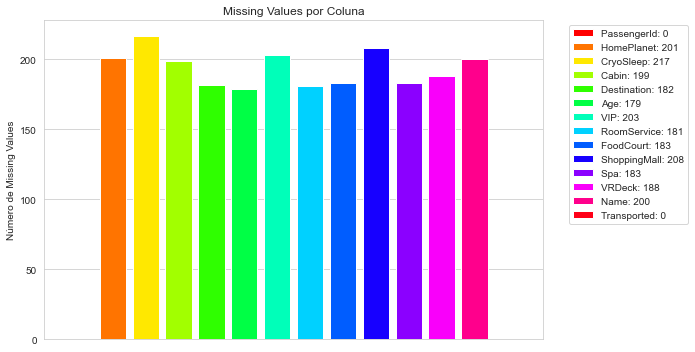

In [56]:
count_miss(train_pd)

Existem mais ou menos uma quantidade igual de *missing values* para cada *feature*, e representam cerca de 2% do total. Na etapa de pré-processamento serão aplicados métodos para a imputação desses valores que faltam.

## Dados numéricos

Vou olhar para os histogramas dos dados numéricos. Vou adicionar uma variável correspondente ao fator limitante de visualização dos gastos (todos features numéricos com excessão da idade são relativos aos gastos dos passageiros aqui). Uma *feature* interessante para criar aqui é o `TotalSpending`, que corresponde ao gasto total por passageiro (ou seja, a soma de todos dados numéricos com excessão da idade). Com ela vem a ideia de criar outra feature `ZeroSpending`, para indicar aqueles passageiros que não gastaram nada. 

In [57]:
# adiciona o valor total gasto por passageiro
train_pd['TotalSpending'] = train_pd[numerical_features[1:]].fillna(0).sum(axis=1)
test_pd['TotalSpending'] = test_pd[numerical_features[1:]].fillna(0).sum(axis=1)
if 'TotalSpending' not in train_pd.columns:
    numerical_features = numerical_features + ['TotalSpending']

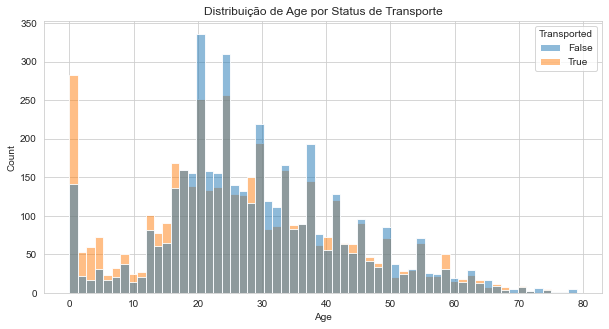

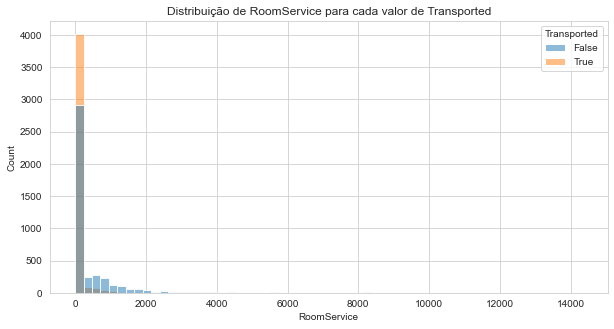

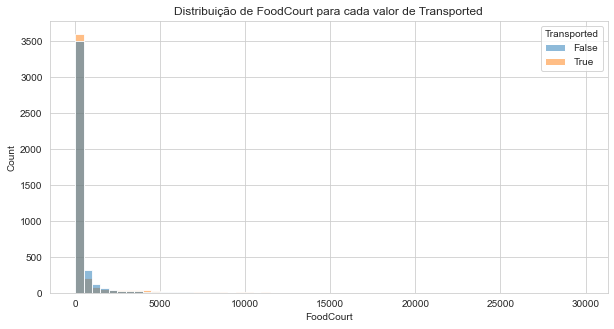

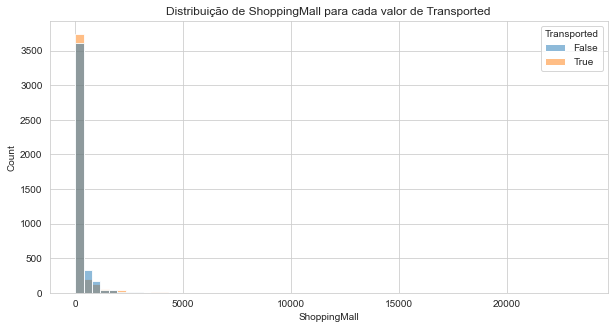

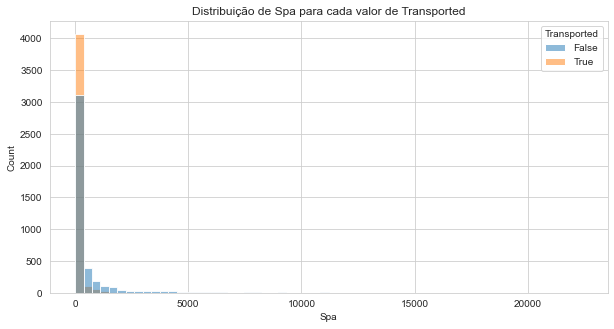

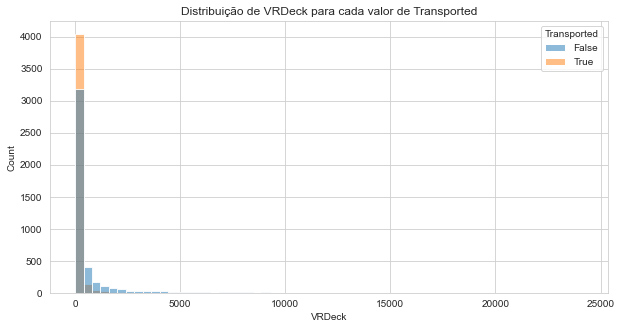

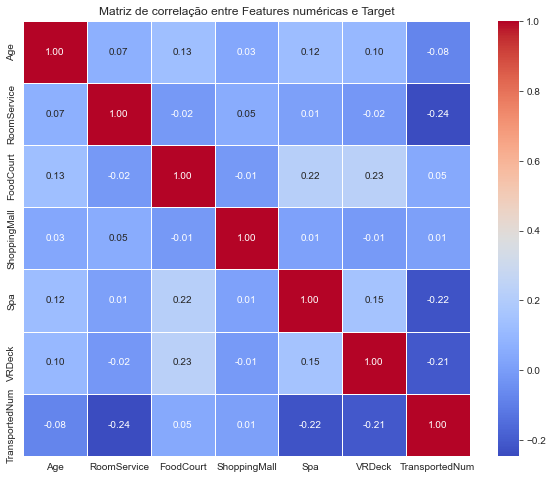

In [58]:
hist_num(train_pd, ftrs=numerical_features, targ='Transported',nolim=['Age'], dscb=False)

Analisando os histogramas acima notei que a maioria das pessoas que foram transportadas **não** gastaram nada, enquanto apenas menos de 1000 pessoas não transportadas deixaram de gastar. Esse padrão se confirma nos gastos detalhados, mas com uma diferença mínima para o `FoodCourt` e `ShoppingMall`.

Como esperado, a correlação entre a *target variable* e as *features* `FoodCourt` e `ShoppingMall` é quase 0, visto que ambas variavam pouco entre transportado ou não nos histogramas observados. Apesar de ainda baixa, existe correlação das demais *features* numéricas de compras com a *target variable*. A idade parece ter relevância apenas com o gasto total. Lembrando que estamos verificando apenas a correlação linear. 

A distribuição de gastos totais é a consequência das demais *features* com execessão da idade. Como já falei, existem uma correlaçao das pessoas que não gastaram e a variável alvo, o que sugere a criação de uma nova *feature* `ZeroSpending`, que é uma coluna binária indicando quem gastou algo (1 para `TotalSpending > 0` e 0 para `TotalSpending = 0`). Não há necessidade de criar para as demais *features* de gasto, já que estão compreendidas em `TotalSpendig`. 

O histograma de `Age` indica algumas faixas de idade suscetíveis à ser transportado ou não. Uma ideia então é criar colunas binárias indicando se aquele passageiro pertence à uma faixa etária específica. Analisando o histograma as faixas etárias apropriadas podem ser: 0-18 anos, 19-35 anos, 36-50 anos e +50 anos.

In [59]:
# adiciona uma coluna binária indicando se o passageiro gastou ou não
train_pd['ZeroSpending'] = (train_pd['TotalSpending']==0).astype(int)
test_pd['ZeroSpending'] = (test_pd['TotalSpending']==0).astype(int)
if 'ZeroSpending' not in train_pd.columns:
    binary_features = binary_features + ['ZeroSpending']

In [60]:
# adiciona as colunas com as faixas de idade

#0-18 anos
train_pd['0_18_years_old'] = (train_pd['Age']<=18).astype(int)
test_pd['0_18_years_old'] = (test_pd['Age']<=18).astype(int)

#19-35 anos
train_pd['19_35_years_old'] = train_pd['Age'].between(19, 35, inclusive='both').astype(int)
test_pd['19_35_years_old'] = test_pd['Age'].between(19, 35, inclusive='both').astype(int)

#36-50 anos
train_pd['36_50_years_old'] = train_pd['Age'].between(36, 50, inclusive='both').astype(int)
test_pd['36_50_years_old'] = test_pd['Age'].between(36, 50, inclusive='both').astype(int)

#+50 anos
train_pd['plus50_years_old'] = (train_pd['Age']>50).astype(int)
test_pd['plus50_years_old'] = (test_pd['Age']>50).astype(int)

## Dados categóricos e binários

Aqui é utilizado o *pie plot* como método de visualização para ambos os tipos de dados. Já que estou olhando apenas para os dados categóricos de baixa cardinalidade (poucos valores únicos), essa visualização é ideal, onde os dados binários possuem apenas 2 valores únicos: `True` ou `False`.

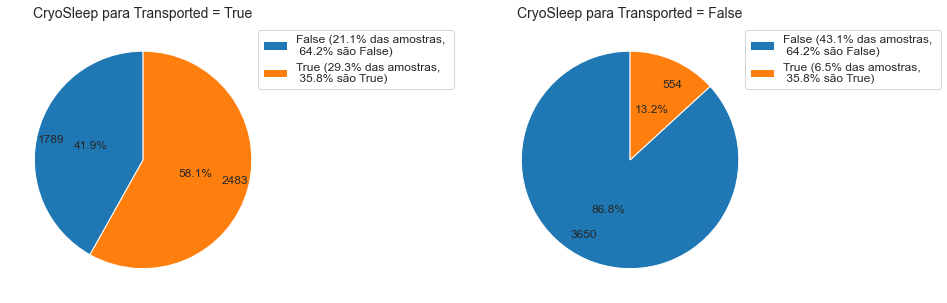

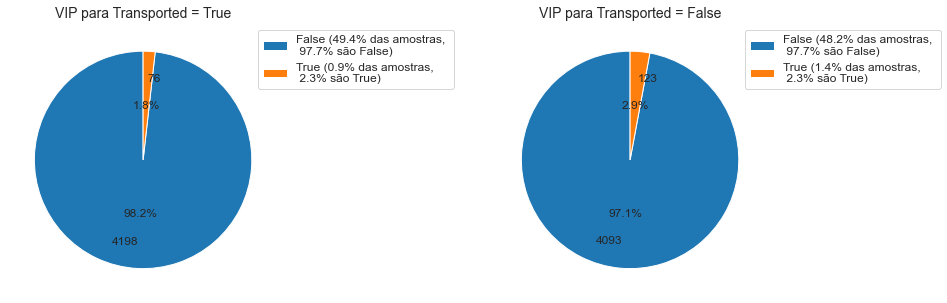

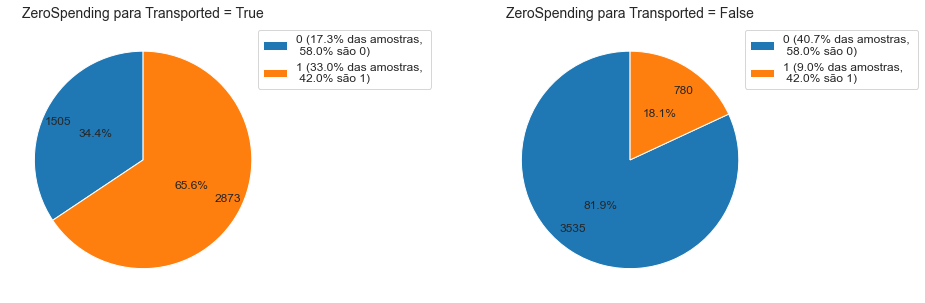

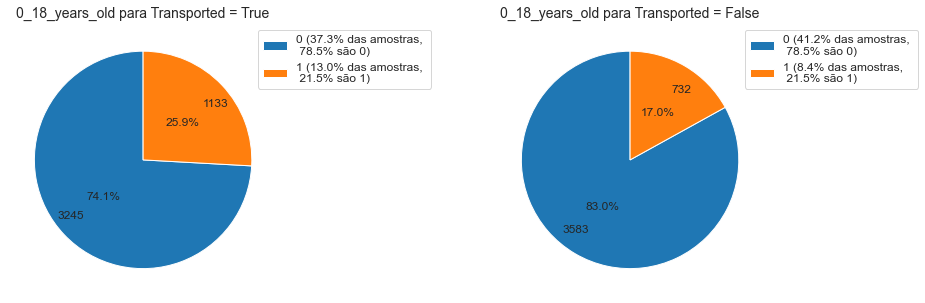

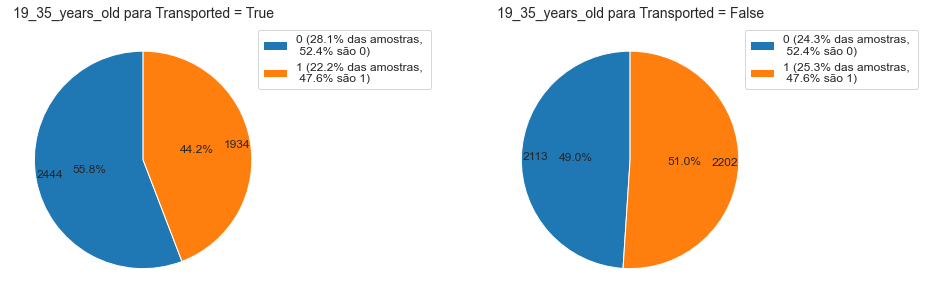

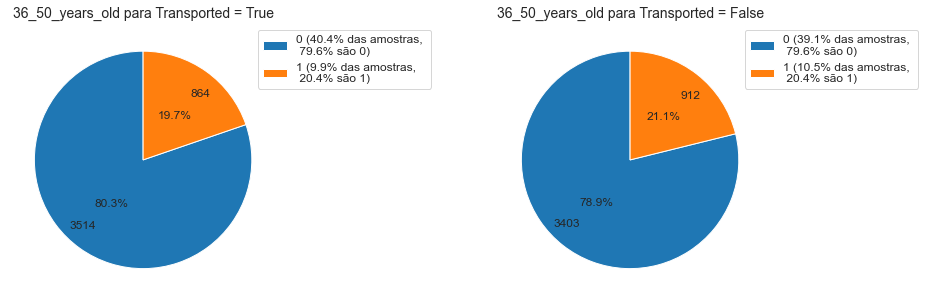

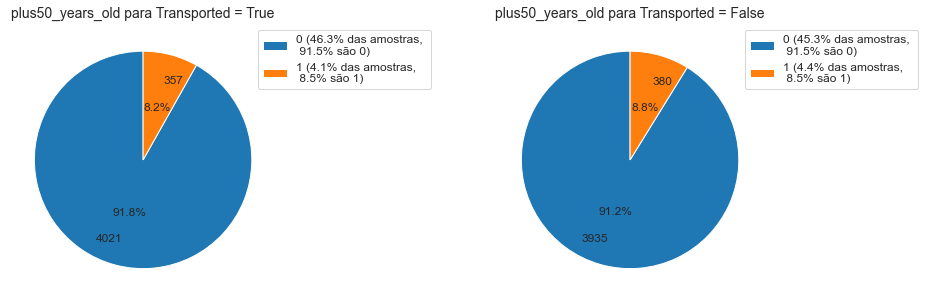

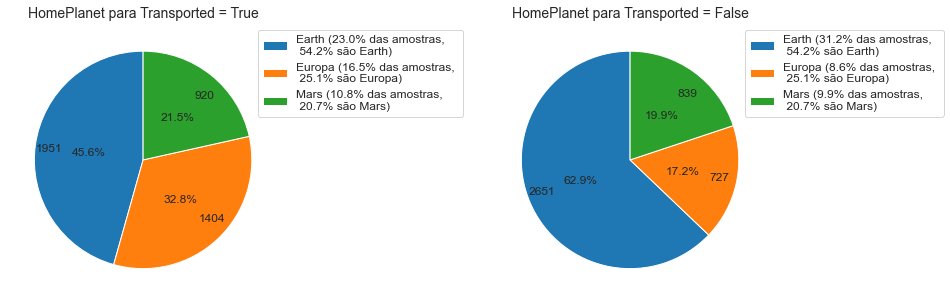

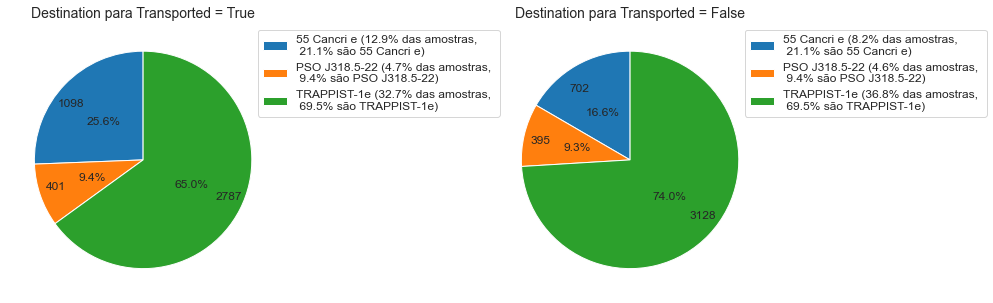

In [61]:
binary_features = ['CryoSleep', 'VIP', 'ZeroSpending', '0_18_years_old', '19_35_years_old', '36_50_years_old', 'plus50_years_old']
pieplots(train_pd, binary_features+categorical_features, targ='Transported', dscb=False)

Os gráficos acima podem parecer cheios de informação, mas decidi colocá-las para analisar o valor relativo de cada um. Por exemplo, quem iria para TRAPPIST-1e representa 65% das pessoas transportadas, mas 69.5% do total tem destino final TRAPPIST-1e, então parece não existir uma correlação entre esse destino e a *target variable*. Por outro lado, 45.6% das pessoas transportadas vieram da terra, enquanto que 54.2% do total tem essa mesma origem, indicando uma possível relação entre pessoas transportadas e seu planeta de origem. Tal correlação com o planeta de origem existe de maneira invertida com Europa, e parece não existir para Marte (ou seja, a porcentagem das pessoas transportadas ou não que vierem de Marte é bem parecida). 

Já para os dados binários podemos observar que 64.2% dos passageiros NÃO estavam em sono criogênico, mas apenas 41.9% destes foram transportados. Indicando uma possível probabilidade maior de ter sido transportado se estiver em sono criogênico. As pessoas VIP representam uma parcela pequena da população (2.3%), impossibilitando concluir algo relevante. 

## Dados de teste

Aqui é aplicada a mesma visualização anterior com uma ligeira diferença. Aqui não temos a variável alvo, pois é justamente aqui que queremos prever essa variável. Então serão observados apenas a distribuição dos dados para ver se a distribuição é parecida com os dados de treinamento. Esse é um passo crucial para identificar se os dados usados no treinamento de fato se parecem com os dados de teste. Essa diferença de distribuição é chamada de *distribution drift*.

       PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
count         8693       8492      8476     8494         8511  8514.000000   
unique        8693          3         2     6560            3          NaN   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
freq             1       4602      5439        8         5915          NaN   
mean           NaN        NaN       NaN      NaN          NaN    28.827930   
std            NaN        NaN       NaN      NaN          NaN    14.489021   
min            NaN        NaN       NaN      NaN          NaN     0.000000   
25%            NaN        NaN       NaN      NaN          NaN    19.000000   
50%            NaN        NaN       NaN      NaN          NaN    27.000000   
75%            NaN        NaN       NaN      NaN          NaN    38.000000   
max            NaN        NaN       NaN      NaN          NaN    79.000000   

          VIP   RoomService     FoodCourt  ShoppingMall        

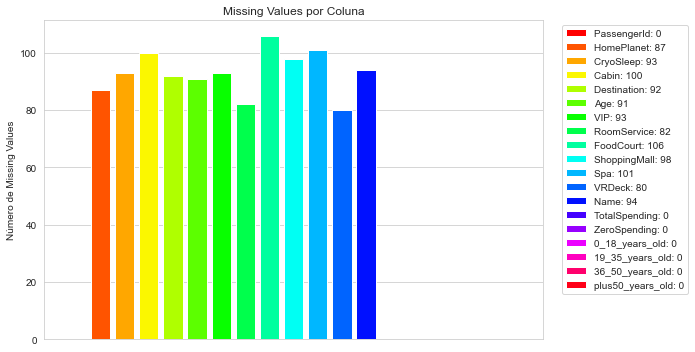

In [62]:
print(train_pd.describe(include='all')) # printando novamente para comparar com os dados de teste
count_miss(test_pd)

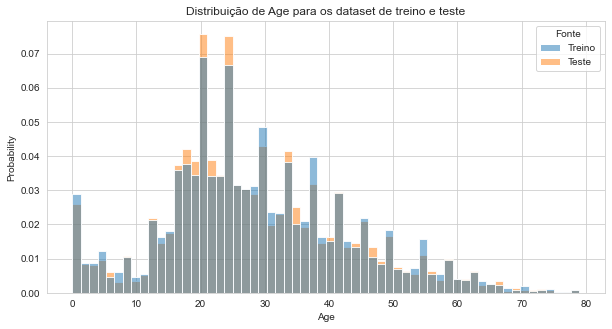

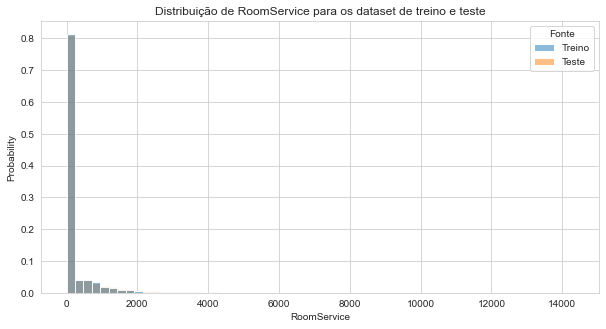

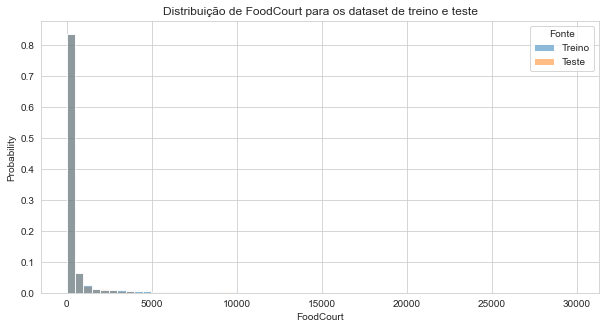

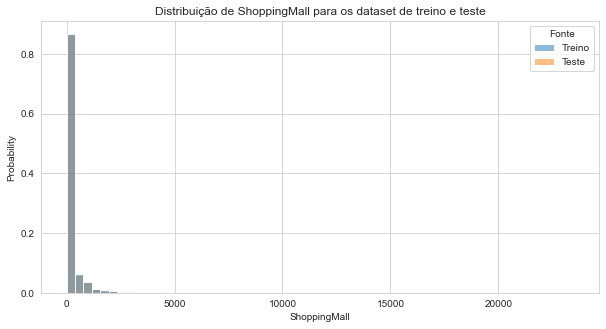

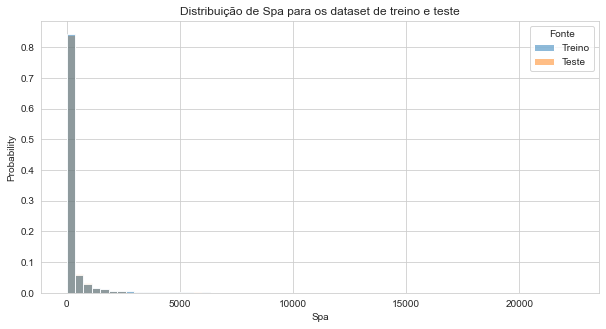

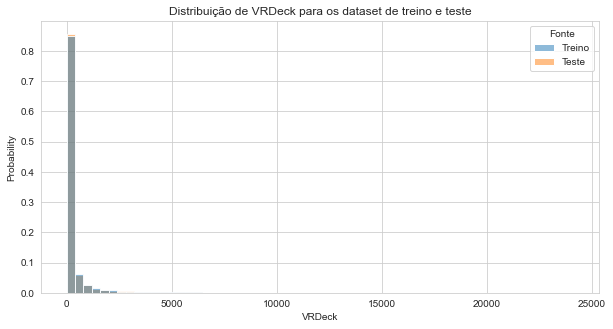

In [63]:
hist_num(train_pd, numerical_features, targ='Transported', nolim=['Age'], dscb=False, df_test = test_pd)

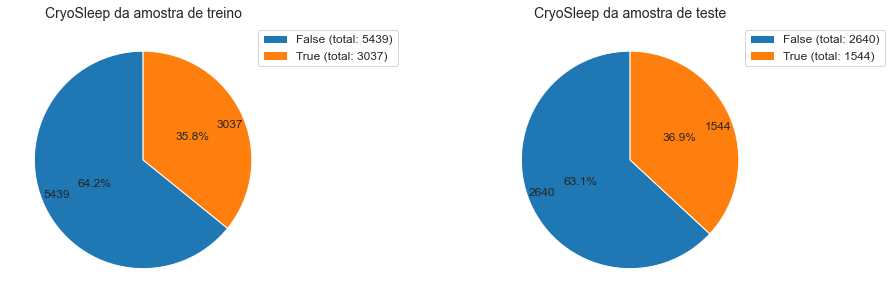

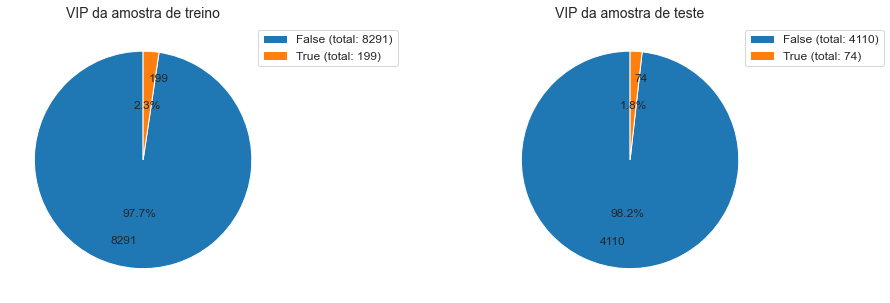

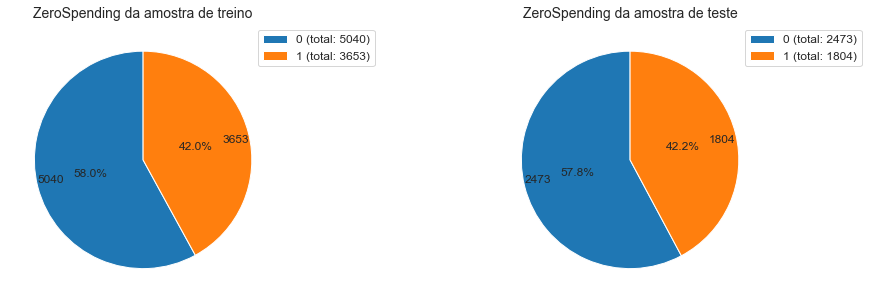

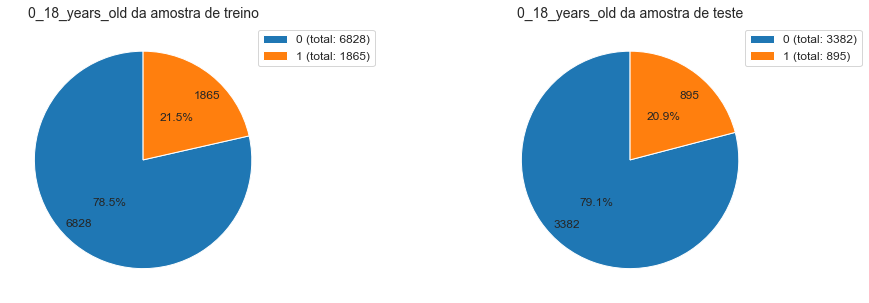

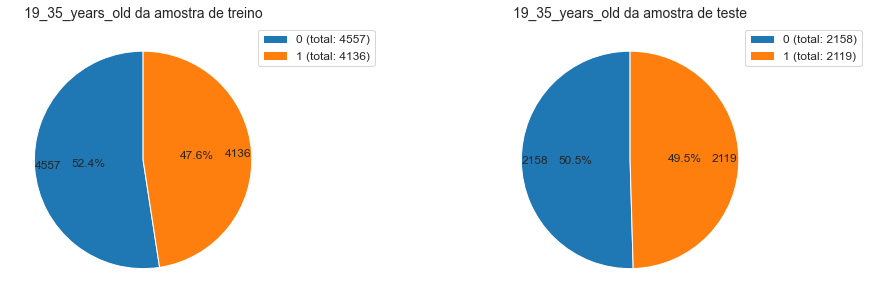

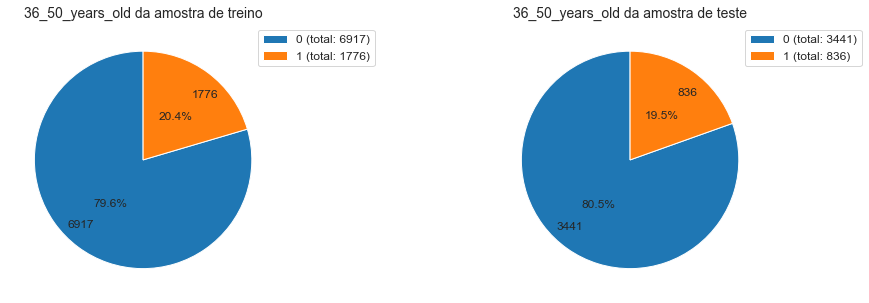

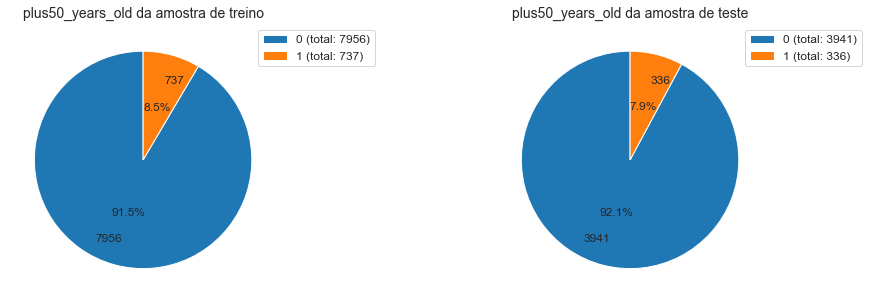

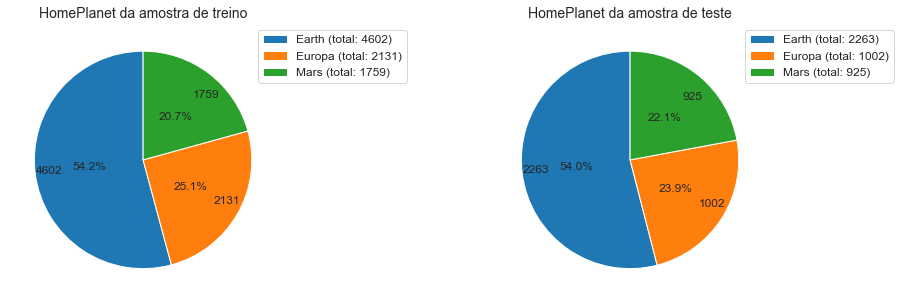

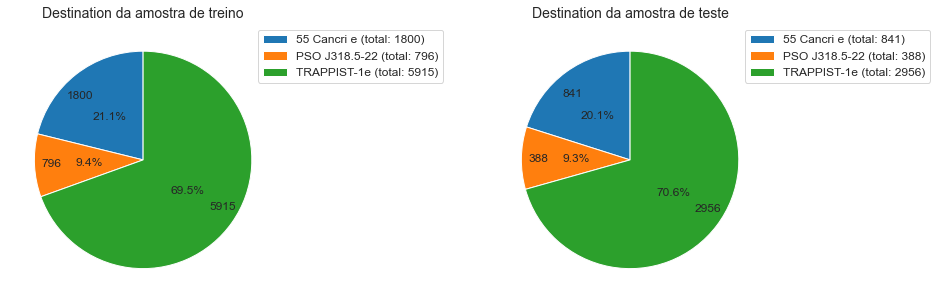

In [64]:
pieplots(train_pd, binary_features+categorical_features, targ='Transported', df_test = test_pd, dscb=False)

As distribuições estão bem parecidas, a descrição dos dataframes mostram que os valores únicos mais frequentes são os mesmos nos dados categóricos e binários, além da moda nos valores numéricos (zero) de gastos também ser igual (evidenciado pelos percentis na descrição). As distribuições de idades também estão bem parecidas. Essas conclusões indicam que o conjunto é muito bom para previsão dos dados.

## Nova *feature*: observando os dados categóricos de alta cardinalidade

Dados categóricos de alta cardinalidade (muitos valores únicos) tornam métodos de codificação com o *one-hot encoding* ineficazes, pois aumenta muito o número de colunas e de primeiro momento não trazem nenhuma informação relevante. Cada *dataset* exige uma abordagem específica. Aqui vou olhar para as *features* `PassengerId` e `Cabin`. Por se tratar de uma análise um pouco mais complexa, diferente do raciocínio direto quando criei a *feature* `TotalSpending`, resolvi separar essa análise das demais. Primeiro vou começar descrevendo ambas *features*:

**PassengerId**: É o número de identificação do passageiro, e possui o formato `gggg_pp`, onde `gggg` corresponde ao grupo que o passageiro está viajando e `pp` ao seu número dentro do grupo. Geralmente pessoas da mesma família viajam no mesmo grupo.

**Cabin**: É o número da cabine onde o passageiro está viajando, e possui o formato `deck/num/side`, onde `side` pode ser `P` para bombordo ou `S` para estibordo.

De cara podemos criar uma *feature* que indica o tamanho total do grupo em que um passageiro está inserido. Para isso devo agrupar as cabines e contar os elementos de cada grupo. Características como "pessoas em grupos maiores tendem a ter sido transportadas" são conclusões que podemos ter a partir da análise dessa *feature*. 

Para `Cabin` é um pouco mais complicado tirar conclusões. Uma *feature* que talvez contenha alguma correlação com a variável alvo é o lado. Podemos verificar se passageiros à bombordo tendem ou não a terem sido transportados. Vou separar essa *feature* em 3: `deck`, `num` e `side` e checar a distribuição de todas.

### Criando a *feature* `GroupSize`

Primeiro, vamos criar a coluna com o tamanho do grupo de cada passageiro. Como não há *missing values* para o `PassengerId` criar essa coluna fica um pouco mais fácil.

In [65]:
# separando os dados em 2 colunas e criando uma variável nova para os números dos grupos
if ('GroupNum' not in train_pd.columns) and ('PassengerNum' not in train_pd.columns):
    Pids = train_pd['PassengerId'].str.split('_', expand=True)
    Pids.columns = ['GroupNum', 'PassengerNum']
    train_pd = train_pd.join(Pids)
    train_pd = train_pd.drop('PassengerId', axis=1)
gp_id = train_pd['GroupNum']

# Agrupando os numeros dos grupos, e depois expandindo pelo tamanho de cada um
# com o mesmo índice das linhas de train_pd
train_pd['GroupSize'] = gp_id.groupby(gp_id).transform('size')

Agora vamos exibir um *pie plot* com a distribuição de tamanho de grupos. Essa *feature* pode ser tratada como um valor categórico para a visualização, onde cada tamanho de grupo é um valor único. 

Aqui eu poderia aplicar minha função para *pie plots*, mas pode ser um pouco mais difícil tirar informações e o plot fica bem poluído. Vou criar uma visualização específica para esse tipo de dado, e depois do plot vai ficar mais claro o motivo de eu fazer isso.

Text(0.5, 1.0, 'Distribuição de tamanhos de grupos\ndos passageiros NÃO transportados')

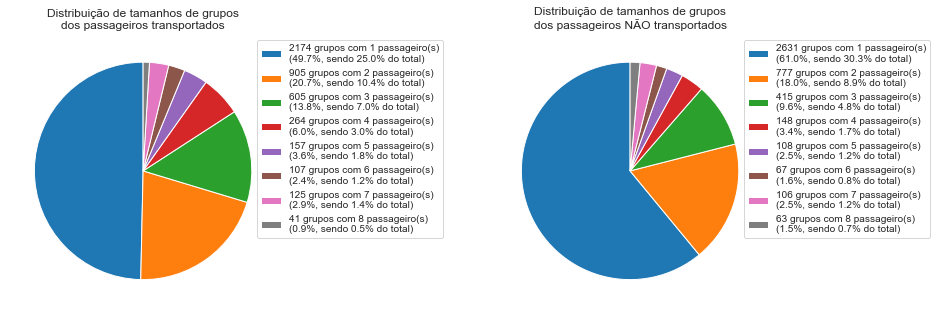

In [66]:

# pie plot da distribuição de tamanhos dos grupos
sns.set_style('whitegrid')
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5))

#primeiro plot
count_tr = train_pd[train_pd['Transported']==True]['GroupSize'].value_counts().sort_index()
ax1.pie(
    count_tr,
    startangle=90,
    textprops={'fontsize':12}
)
ax1.legend(
    [f'{val} grupos com {idx} passageiro(s)\n({val/sum(count_tr)*100:.1f}%, sendo {val/train_pd.shape[0]*100:.1f}% do total)' for idx,val in count_tr.items()],
    bbox_to_anchor=(.9,1)
)
ax1.set_title(f'Distribuição de tamanhos de grupos\ndos passageiros transportados')

#segundo plot
count_nottr = train_pd[train_pd['Transported']==False]['GroupSize'].value_counts().sort_index()
ax2.pie(
    count_nottr,
    startangle=90,
    textprops={'fontsize':12}
)
ax2.legend(
    [f'{val} grupos com {idx} passageiro(s)\n({val/sum(count_nottr)*100:.1f}%, sendo {val/train_pd.shape[0]*100:.1f}% do total)' for idx,val in count_nottr.items()],
    bbox_to_anchor=(.9,1)
)
ax2.set_title(f'Distribuição de tamanhos de grupos\ndos passageiros NÃO transportados')

A distribuição acima parece indicar uma certa correlação entre ser transportado ou não e o tamanho do grupo do passageiro. A maioria (só um pouco mais que a metade) das pessoas transportadas estavam viajando em grupos de 2 ou mais pessoas (os grupos de 1 pessoa representa menos da metade das pessoas transportadas). Já para as pessoas não transportadas, a maioria estava sozinha (61% das pessoas não transportadas estavam sozinhas). Portanto a *feature* `GroupSize` aqui criada parece ser uma boa candidata à fornecer informações valiosas para nosso modelo. 

### *Feature* `Cabin`

Antes de sair criando *features* aqui eu preciso dar uma olhada na distribuição de cada coisa que a *feature* `Cabin` representa. Vamos separar em  `deck`, `num` e `side`, adicioná-las como novas features e checar suas distribuições

In [67]:
tags = ['deck', 'num', 'side']
if (tags[0] not in train_pd.columns) and (tags[1] not in train_pd.columns) and (tags[2] not in train_pd.columns):
    cab_ftrs = train_pd['Cabin'].str.split('/', expand=True)
    cab_ftrs.columns = tags
    train_pd = train_pd.join(cab_ftrs)
    train_pd = train_pd.drop('Cabin', axis = 1)

In [68]:
count_deck = train_pd['deck'].value_counts().sort_index()
count_num = train_pd['num'].value_counts().sort_index()
count_side = train_pd['side'].value_counts().sort_index()
print(count_deck)
print(count_num)
print(count_side)

A     256
B     779
C     747
D     478
E     876
F    2794
G    2559
T       5
Name: deck, dtype: int64
0       18
1       15
10      12
100     12
1000     6
        ..
995      3
996      1
997      2
998      4
999      6
Name: num, Length: 1817, dtype: int64
P    4206
S    4288
Name: side, dtype: int64


Podemos observar que existem 8 decks, 1817 números de cabines e apenas 2 lados. Vamos olhar se as colunas com poucos valores únicos possuem alguma correlação com a variável alvo. 

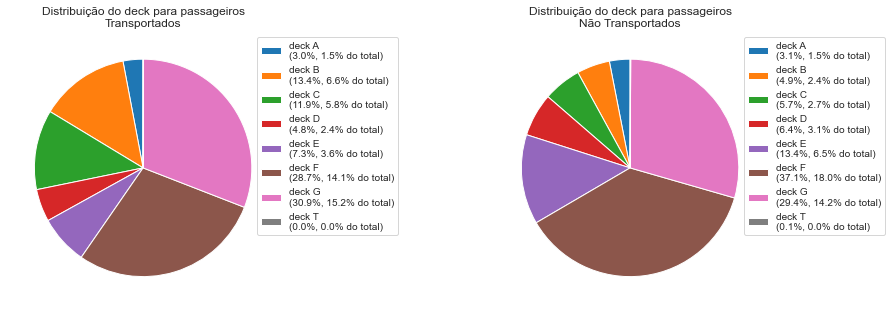

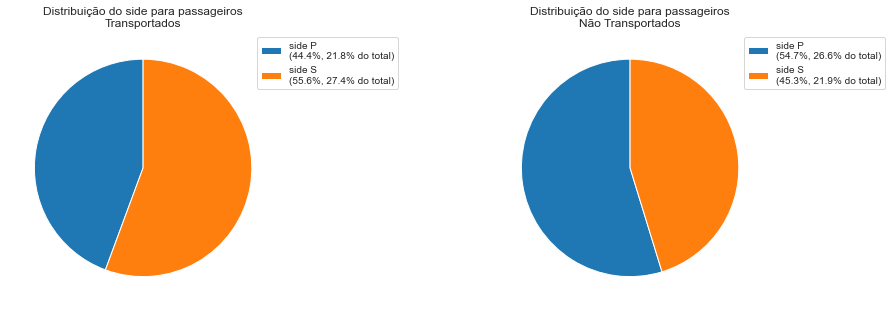

In [69]:
for col in tags:
    if col == 'num':
        continue
    sns.set_style('whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

    #primeiro plot
    count_trans = train_pd[train_pd['Transported']==True][col].value_counts().sort_index()
    ax1.pie(
        count_trans,
        startangle=90,
        textprops={'fontsize':12}
    )
    ax1.set_title(f'Distribuição do {col} para passageiros\nTransportados')
    ax1.legend(
        [f'{col} {idx}\n({val/sum(count_trans)*100:.1f}%, {val/train_pd.shape[0]*100:.1f}% do total)' for idx,val in count_trans.items()],
        bbox_to_anchor=(.9,1)
    )

    #segundo plot
    count_nottrans = train_pd[train_pd['Transported']==False][col].value_counts().sort_index()
    ax2.pie(
        count_nottrans,
        startangle=90,
        textprops={'fontsize':12}
    )
    ax2.set_title(f'Distribuição do {col} para passageiros\nNão Transportados')
    ax2.legend(
        [f'{col} {idx}\n({val/sum(count_nottrans)*100:.1f}%, {val/train_pd.shape[0]*100:.1f}% do total)' for idx,val in count_nottrans.items()],
        bbox_to_anchor=(.9,1)
    )

Aparentemente existem algumas correlação, tanto quanto no deck quanto no lado. Por exemplo, dos passageiros transportados apenas 7.3% estavam no **deck E** enquanto 13.4% dos passageiros não transportados estavam no mesmo deck. A maioria das pessoas transportadas tiveram uma tendência maior de estar no lado S do que no P. Vou manter as novas *features* `deck` e `side`, tratando-as como categórica e binária respectivamente.

## Pré processamento dos dados

Agora vem um passo importante no treinamento do modelo. Após analisar a distribuição das *features* e verificar sua correlação com a variável alvo, chegou a hora de tornar os dados "imputaveis" no treinamento do nosso modelo. Resumidamente para esse caso isso significa lidar com os *missing values* e codificar os dados não numéricos.

### Imputação dos *missing values* e codificação dos dados não numéricos

Todas as colunas com excessão da `PassengerId` possuem "buracos", ou seja, para alguns passageiros não temos todas as informações disponíveis. Uma opção rápida é excluir essas linhas que não contém todas informações, mas isso excluiria muitos dados. Portanto vou aplicar estratégias para substituir esses valores de acordo com o tipo de dado. 
Algumas das escolhas aqui podem variar de acordo com o modelo. Para esse *dataset* vou usar o modelo *Random Forest*, onde darei mais detalhes da minha escolha no notebook do modelo. É um modelo robusto, recomendado para problemas de classificação, que lida bem com colunas que não fornecem muita informação (ele seleciona as que mais fornecem informação para a variável alvo). Aqui estão as estratégia que vou usar:

**Dados numéricos**: Vou substituir os *missing values* dos dados numéricos pela mediana. É uma boa estratégia quando se tem alguns *outliers* (valores muito distantes dos demais), apesar do modelo lidar bem com *outlier* ainda é uma estratégia válida.

**Dados categóricos**: O método de codificação aqui é o *one-hot encoding*, onde eu vou criar uma coluna para cada valor único e cada linha recebe um valor binário (0 ou 1), representando se aquela coluna tem ou não aquele valor único. Aqui os *missing values* são tratados como um valor único, portanto o código cria uma nova coluna para indicar se naquela linha faltava ou não o dado.

**Dados binários**: São dados que vem na forma `True` ou `False`, portanto basta substituir por 1 e 0 respectivamente. Vou substituir os *missing values* pela moda (valor mais frequente). 

Vou definir funções para cada tipo de dado, que devolvem as colunas que quero tratar. Lembrando que preciso adicionar as novas features no tratamento.

In [70]:
categorical_features = categorical_features + ['GroupSize', 'deck']
binary_features = binary_features + ['side']

In [71]:
#processando dados categóricos
def process_categ(categorical, add_nan=True):
    new_categ = pd.get_dummies(categorical, dummy_na=add_nan, dtype=int) 
    return new_categ

#processando dados binários
def process_bin(binary, add_nan=True):
    cols = []
    for col_name in binary.columns:
        if add_nan:
            nan_ind = binary[col_name].isna().astype(int)
            nan_ind.name = f"{col_name}_isnan"
            cols.append(nan_ind)

        bool2int = binary[col_name].fillna(False).astype(int)
        bool2int.name = col_name
        cols.append(bool2int)

    new_bin = pd.DataFrame()
    if cols:
        new_bin = pd.concat(cols, axis=1)
    return new_bin

#processando dados numéricos
def process_num(numerical, normalize=True, add_nan=True):
    nan_df = pd.DataFrame()
    if add_nan:
        nan_list = []
        for col_name in numerical.columns:
            indicator = numerical[col_name].isna().astype(int)
            indicator.name = f"{col_name}_isnan"
            nan_list.append(indicator)

        if nan_list:
            nan_df = pd.concat(nan_list, axis=1)

    new_num = numerical.copy()
    medians = new_num.median()
    new_num = new_num.fillna(medians)

    if normalize:
        mins = new_num.min()
        maxs = new_num.max()
        range = maxs - mins
        new_num = (new_num - mins) / range

    if add_nan and not nan_df.empty:
        final_df = pd.concat([new_num, nan_df], axis=1)
    else:
        final_df = new_num

    return final_df

In [72]:
categorical_features = ['HomePlanet', 'Destination', 'GroupSize']
binary_features = ['CryoSleep', 'ZeroSpending']
# binary_features = ['CryoSleep', 'ZeroSpending', '0_18_years_old', '19_35_years_old', '36_50_years_old', 'plus50_years_old']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending']

train_pd['side'] = train_pd['side'].replace({'S': 1, 'P': 0})
new_bin_tr = process_bin(train_pd[binary_features],add_nan=False)
new_cat_tr = process_categ(train_pd[categorical_features], add_nan=False)
new_num_tr = process_num(train_pd[numerical_features], normalize=False, add_nan=False)

new_train = pd.concat([new_bin_tr,new_cat_tr,new_num_tr],axis=1)

new_train.shape

(8693, 16)

### Aplicando todas transformações nos dados de teste

Aqui vou aplicar as mesmas transformações nos dados de teste, e salvar os dados como arquivos .csv para que eu possa carregá-los e aplicar no código que treinar o modelo. 

In [73]:
# separando os dados em 2 colunas e criando uma variável nova para os números dos grupos
if ('GroupNum' not in test_pd.columns) and ('PassengerNum' not in test_pd.columns):
    Pids = test_pd['PassengerId'].str.split('_', expand=True)
    Pids.columns = ['GroupNum', 'PassengerNum']
    test_pd = test_pd.join(Pids)
gp_id = test_pd['GroupNum']

# Agrupando os numeros dos grupos, e depois expandindo pelo tamanho de cada um
# com o mesmo índice das linhas de test_pd
test_pd['GroupSize'] = gp_id.groupby(gp_id).transform('size')

In [74]:
tags = ['deck', 'num', 'side']
if (tags[0] not in test_pd.columns) and (tags[1] not in test_pd.columns) and (tags[2] not in test_pd.columns):
    cab_ftrs = test_pd['Cabin'].str.split('/', expand=True)
    cab_ftrs.columns = tags
    test_pd = test_pd.join(cab_ftrs)
    test_pd = test_pd.drop('Cabin', axis = 1)

In [75]:
test_pd['side'] = test_pd['side'].replace({'S': 1, 'P': 0})
new_bin_ts = process_bin(test_pd[binary_features],add_nan=False)
new_cat_ts = process_categ(test_pd[categorical_features], add_nan=False)
new_num_ts = process_num(test_pd[numerical_features], normalize=False, add_nan=False)

new_test = pd.concat([new_bin_ts,new_cat_ts,new_num_ts],axis=1)

new_test.shape

(4277, 16)

In [76]:
new_train['Transported'] = Y_train
new_test['PassengerId'] = test_pd['PassengerId']
new_train.to_csv('train_processed.csv', index=False, encoding='utf-8')
new_test.to_csv('test_processed.csv', index=False, encoding='utf-8')